In [21]:
import time
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris

role = get_execution_role()

bucket = sagemaker.Session().default_bucket()

training_image = image_uris.retrieve(
    region=boto3.Session().region_name, framework="image-classification"
)

In [22]:
session = boto3.Session(profile_name='sandbox')

In [23]:
# For this training, we will use 18 layers
num_layers = "18"
# we need to specify the input image shape for the training data
image_shape = "1000,1000"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
num_training_samples = "100"
# specify the number of output classes
num_classes = "2"
# batch size for training
mini_batch_size = "50"
# number of epochs
epochs = "2"
# learning rate
learning_rate = "0.01"

In [24]:
job_name_prefix = "task-4-imageclassification"
job_name = job_name_prefix + "-" + time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
training_params = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "Pipe"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, job_name_prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.p3.2xlarge", "VolumeSizeInGB": 50},
    "TrainingJobName": job_name,
    "HyperParameters": {
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate)
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 360000},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "AttributeNames": ["source-ref", "class"],
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": "s3://dug-cloud-manifest/cloud_training_3.json",
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None",
            "RecordWrapperType": "RecordIO"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "AttributeNames": ["source-ref", "class"],
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": "s3://dug-cloud-manifest/cloud_validation_3.json",
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None",
            "RecordWrapperType": "RecordIO"
        }
    ]
}
    
print("Training job name: {}".format(job_name))
print(
    "\nInput Data Location: {}".format(
#        training_params["InputDataConfig"][0]["DataSource"]["S3DataSource"]
#    )
        training_params
    )
)

Training job name: task-4-imageclassification--2022-09-30-19-53-01

Input Data Location: {'AlgorithmSpecification': {'TrainingImage': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:1', 'TrainingInputMode': 'Pipe'}, 'RoleArn': 'arn:aws:iam::286258962151:role/service-role/AmazonSageMaker-ExecutionRole-20210903T160549', 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-west-2-286258962151/task-4-imageclassification/output'}, 'ResourceConfig': {'InstanceCount': 1, 'InstanceType': 'ml.p3.2xlarge', 'VolumeSizeInGB': 50}, 'TrainingJobName': 'task-4-imageclassification--2022-09-30-19-53-01', 'HyperParameters': {'num_layers': '18', 'num_training_samples': '100', 'num_classes': '2', 'mini_batch_size': '50', 'epochs': '2', 'learning_rate': '0.01'}, 'StoppingCondition': {'MaxRuntimeInSeconds': 360000}, 'InputDataConfig': [{'ChannelName': 'train', 'DataSource': {'S3DataSource': {'AttributeNames': ['source-ref', 'class'], 'S3DataType': 'AugmentedManifestFile', 'S3Uri': 's3:

In [25]:
# create the Amazon SageMaker training job
sagemaker = session.client(service_name="sagemaker")
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print("Training job current status: {}".format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info["TrainingJobStatus"]
    print("Training job ended with status: " + status)
except:
    print("Training failed to start")
    # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)["FailureReason"]
    print("Training failed with the following error: {}".format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [26]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info["TrainingJobStatus"]
print("Training job ended with status: " + status)

Training job ended with status: Completed


In [27]:
model_name = "DEMO-full-image-classification-model" + time.strftime(
    "-%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(model_name)
info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

hosting_image = image_uris.retrieve(
    region=session.region_name, framework="image-classification"
)

primary_container = {
    "Image": hosting_image,
    "ModelDataUrl": model_data,
}

create_model_response = sagemaker.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

DEMO-full-image-classification-model-2022-09-30-19-59-09
s3://sagemaker-us-west-2-286258962151/task-4-imageclassification/output/task-4-imageclassification--2022-09-30-19-53-01/output/model.tar.gz
arn:aws:sagemaker:us-west-2:286258962151:model/demo-full-image-classification-model-2022-09-30-19-59-09


In [28]:
from time import gmtime, strftime

timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config_name = job_name_prefix + "-epc-" + timestamp
endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint configuration name: {}".format(endpoint_config_name))
print("Endpoint configuration arn:  {}".format(endpoint_config_response["EndpointConfigArn"]))

Endpoint configuration name: task-4-imageclassification-epc--2022-09-30-19-59-11
Endpoint configuration arn:  arn:aws:sagemaker:us-west-2:286258962151:endpoint-config/task-4-imageclassification-epc--2022-09-30-19-59-11


In [29]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_name = job_name_prefix + "-ep-" + timestamp
print("Endpoint name: {}".format(endpoint_name))

endpoint_params = {
    "EndpointName": endpoint_name,
    "EndpointConfigName": endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print("EndpointArn = {}".format(endpoint_response["EndpointArn"]))

Endpoint name: task-4-imageclassification-ep--2022-09-30-19-59-16
EndpointArn = arn:aws:sagemaker:us-west-2:286258962151:endpoint/task-4-imageclassification-ep--2022-09-30-19-59-16


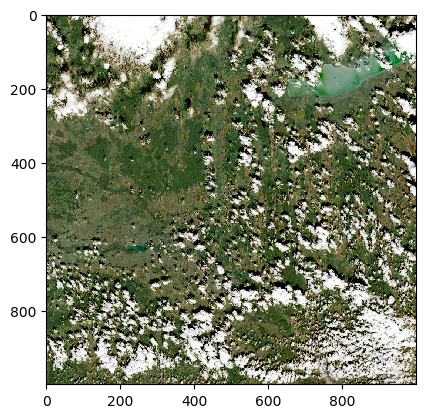

Result: [0.2581403851509094, 0.7418596148490906]
This image is cloudy


In [37]:
object_categories = [
    "clear",
    "cloudy"
]
runtime = session.client(service_name="runtime.sagemaker")

file_name = "/tmp/test_1.jpg"
s3_client = boto3.client("s3")
s3_client.download_file(
    "dug-cloud-test",
    "test_1.jpg",
    file_name,
)

 # test image
from IPython.display import Image
from PIL import Image as Im
import matplotlib.pyplot as plt

Image(file_name)

img = Im.open(file_name)

imgplot = plt.imshow(img)
plt.show(imgplot)     

import json
import numpy as np
import matplotlib.pyplot as plt

img = open(file_name, 'rb').read()
    
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=bytearray(img)
)

result = response["Body"].read()

# result will be in json format and convert it to ndarray
result = json.loads(result)
print("Result: " + str(result))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
print("This image is " + object_categories[index])

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)